# Red Round Sign Detection

## Part 1 : Dataset

The dataset used for this problem is GTSDB dataset. Below are some of the observations about the dataset:

* Train dataset : 600 images

* Test dataset : 300 images

* Image size : 1360 x 800 x 3(one channel each for R, G and B)

### Distribution of classes
As we can see from the below plot, the dataset has class imbalance which makes it harder to classify the traffic sign to correct label. But in our case, since we are only concerned about object detection, class imbalance should not cause any issue.

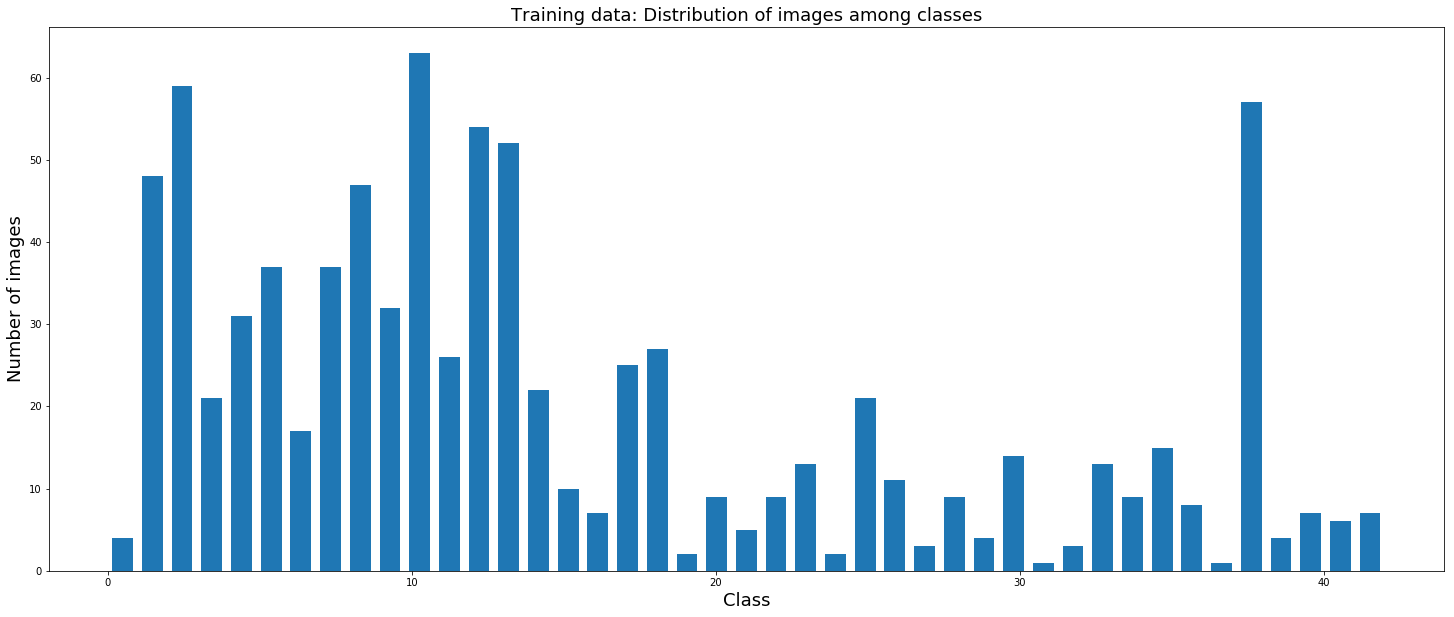

In [44]:
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv("traffic_sign/TrainIJCNN2013/gt.txt", sep=';', header = None)
plt.figure(figsize=(25,10))
n_classes = len(np.unique([dataset.iloc[:,-1]]))
hist, bins = np.histogram([dataset.iloc[:,-1]], bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

plt.title('Training data: Distribution of images among classes', fontsize=18)
plt.xlabel('Class', fontsize=18)
plt.ylabel('Number of images', fontsize=18)

plt.show()

## Loading the data using dataloader (PyTorch)

### Creating the dataset class
Reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

_torch.utils.data.Dataset_ is an abstract class representing a dataset. 

GTSDBDataset inherits this class and overrides following method: \_\_len__ and \_\_getitem__

In [45]:
class GTSDBDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file, sep=';')
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:-1].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 1)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample['image'] = self.transform(image)
        return sample

## Data Loader and Transforms

### Handling data size

_torch.utils.data.DataLoader_ is an iterator to iterate through the data set. It provides multiple features which solve most of the problems we face with the data:
* Shuffling the data: Shuffling the order of data samples makes the model robust and helps to achieve better results as in each pass(epoch) we will feed a different set of batches.

* Batching and multiprocessing the data: Feeding the data samples in batches with multiple processors producing the batches makes data preparation process (for training) more efficient.

* Resizing the image: Resizing to scale down the image solves the problem of input size, but Region of Interest (ROI) needs to be changed accordingly. This approach might fail if the ROI is near edges of the image. But, in real world application of self-driving cars, if a sign board is too far, it might not be relevant at current time.


In [101]:
gtsdb_datasets = []
data_transforms = {'Brightness':[0.8,1.3,1.5], 'Contrast':[0.1, 0.4]}
for b in data_transforms['Brightness']:
    for c in data_transforms['Contrast']:
        gtsdb_dataset = GTSDBDataset(csv_file = 'traffic_sign/TrainIJCNN2013/gt.txt',
                                    root_dir = 'traffic_sign/TrainIJCNN2013/',
                                    transform=transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.ColorJitter(brightness=b,contrast=c, saturation=0.0),
                                    transforms.ToTensor()
                                     ]))
        gtsdb_datasets.append(gtsdb_dataset)

In [102]:
dataloaders = []
for dataset in gtsdb_datasets:
    dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=False, num_workers=1)
    dataloaders.append(dataloader)

### Handling different weather and lighting conditions : Transforms

Data augumentation (horizontal flipping, image rotation and mirror images) and transformation (changing brightness and contrast of the images, resizing, rescaling) is a common technique to improve model performance in Deep Learning. 

_torchvision.transforms.Compose_ is a simple callable class used to transform the images. To handle the weather and lighting conditions, we apply the ColorJitter transformation which changes the brightness and contrast of the images.

In [ ]:
images = []
for dataloader in dataloaders:
    for i_batch, sample_batched in enumerate(dataloader):

        if i_batch == 0:
            image = sample_batched['image'][0]
            image = np.transpose(image.numpy(), (1, 2, 0))
            images.append(image)
            break

In [ ]:
f, axarr = plt.subplots(2,3,figsize=(15,8))
r = 0;c = 0
for i in range(len(images)):
    axarr[r,c].imshow(images[i], interpolation='nearest')
    if c == 2: c = 0;r = r+1
    else: c = c+1


### Conclusion:
This document showcases basic analysis of the dataset. As the model is trained, we might need to introduce more data augumentation/transformation based on the model performance and will be included in next parts (Part 2 & 3).